In [ ]:
import json
import matplotlib.pyplot as plt
import requests
import pandas as pd
from pandas import json_normalize
import plotly


In [458]:
url = "https://file.notion.so/f/f/e6d8df69-733e-4793-ae23-13bbf3253b75/56d094a2-79c8-40dd-8693-21874822e3f9/Italy_vs_Czech_Republic.json?id=10107ac4-f3cf-4bf7-8024-189e20bef774&table=block&spaceId=e6d8df69-733e-4793-ae23-13bbf3253b75&expirationTimestamp=1703239200000&signature=dnIgSbK9H3EELnLO-X8znrbLAXahDRhT7CRcOJg6m-M&downloadName=Italy_vs_Czech+Republic.json"

data = json.loads(str(requests.get(url).text))
data # dict

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

* Processing and Adhoc (.json)

In [453]:
event_data = pd.json_normalize(data['events'],
                               record_path='eventTypes',
                               meta = ['eventId', 'eventPeriod', 'eventTime',
                                       'teamId', 'playerId','x','y'],
                               sep='_')

relative_data = pd.json_normalize(data['events'], sep='_')

event_df = pd.merge(event_data,
              relative_data[['relativeEvent_eventId','relativeEvent_playerId',
                             'relativeEvent_x','relativeEvent_y', 'ballPosition_x', 'ballPosition_y', 'eventId']], on='eventId')

player_data = pd.DataFrame(data['players'])

df = pd.merge(event_df,
              player_data[['playerId', 'playerName', 'playerLastName']],
              on='playerId')


df['eventId'] = df['eventId'].astype(int)
df['playerId'] = df['playerId'].astype(float)

df['time_sec'] = df['eventTime'].apply(lambda x : x / 1000)
df['time_min'] = df['time_sec'].apply(lambda  x : x / 60)

#df = df.sort_values('eventTime')

#df[df['eventId'].isin([41254901, 41254923])]
#df.to_csv('base_data.csv')
df

TypeError: list indices must be integers or slices, not str

In [451]:
# 패널티 에어리어 내 이벤트
in_p_area = df[
    ( (df['x'] * 68) >= 13.84) &
    ( (df['x'] * 68) <= 54.16) &
    ( (df['y'] * 105) >= 88.85)
]

in_p_area = in_p_area.sort_values('eventId')
in_p_area

,eventType,outcome,cross,keyPass,assist,subEventType,bodyPart,xG,eventTypes,eventId,...,relativeEvent_eventId,relativeEvent_playerId,relativeEvent_x,relativeEvent_y,ballPosition_x,ballPosition_y,playerName,playerLastName,time_sec,time_min
847,Shot,On Target,NaN,NaN,NaN,NaN,Head,0.03817,NaN,41255000,...,NaN,NaN,NaN,NaN,0.753242,0.284144,Lukas,Masopust,95.382,1.589700
848,Pass Received,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41255000,...,NaN,NaN,NaN,NaN,0.753242,0.284144,Lukas,Masopust,95.382,1.589700
7,Pass Received,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41255121,...,NaN,NaN,NaN,NaN,NaN,NaN,Antonin,Barak,174.179,2.902983
8,Pass,Successful,False,False,False,NaN,NaN,NaN,NaN,41255124,...,41255125.0,210328.0,0.223296,0.960923,NaN,NaN,Antonin,Barak,176.242,2.937367
1841,Pass Received,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41255125,...,41255126.0,NaN,0.595015,0.948034,NaN,NaN,Jakub,Jankto,176.932,2.948867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Duel,Unsuccessful,NaN,NaN,NaN,Ground,NaN,NaN,NaN,41270707,...,NaN,NaN,NaN,NaN,NaN,NaN,Emerson,,4676.913,77.948550
1208,Pass,Successful,False,False,False,NaN,NaN,NaN,NaN,41270804,...,41270805.0,210304.0,0.052075,0.897536,NaN,NaN,Nicolo,Barella,4710.027,78.500450
1209,Pass Received,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41270804,...,41270805.0,210304.0,0.052075,0.897536,NaN,NaN,Nicolo,Barella,4710.027,78.500450
2612,Pass,Unsuccessful,False,False,False,NaN,NaN,NaN,NaN,41274737,...,41274738.0,210311.0,0.782386,0.907664,NaN,NaN,Giacomo,Raspadori,5499.266,91.654433


In [20]:
events_seq_data = pd.json_normalize(
                             data['sequences'],
                             record_path='eventIds',
                             meta=['teamId', 'eventPeriod','startTime','endTime'],
                             sep='_'
)

events_seq_data = events_seq_data.dropna(subset=['teamId'])

events_seq_data = events_seq_data.rename(columns={events_seq_data.columns[0]: 'eventId'})

events_seq_data = pd.merge(events_seq_data, df, on='eventId', how='left')
events_seq_data = events_seq_data.dropna(subset=['eventType'])
events_seq_data = events_seq_data[events_seq_data['eventType'] != 'Pass Received']

#events_seq_data.to_csv('events of sequence.csv')
events_seq_data

,eventId,teamId_x,eventPeriod_x,startTime,endTime,eventType,outcome,cross,keyPass,assist,...,relativeEvent_eventId,relativeEvent_playerId,relativeEvent_x,relativeEvent_y,ballPosition_x,ballPosition_y,playerName,playerLastName,time_sec,time_min
0,41254878,10758,FIRST_HALF,996,6185,Pass,Successful,False,False,False,...,41254879.0,210329.0,0.492469,0.403253,NaN,NaN,Antonin,Barak,0.996,0.016600
2,41254880,10758,FIRST_HALF,996,6185,Pass,Successful,False,False,False,...,41254881.0,210331.0,0.749408,0.300976,NaN,NaN,Vladimir,Darida,2.716,0.045267
4,41254883,10758,FIRST_HALF,996,6185,Pass,Successful,False,False,False,...,41254884.0,210330.0,0.942876,0.415118,NaN,NaN,Ondrej,Celustka,4.892,0.081533
5,41254884,10758,FIRST_HALF,996,6185,Pass,Unsuccessful,False,False,False,...,41254885.0,NaN,0.637419,0.647984,NaN,NaN,Vladimir,Coufal,6.185,0.103083
7,41254911,10757,FIRST_HALF,8061,13394,Pass,Successful,False,False,False,...,41254912.0,210305.0,0.322532,0.516785,NaN,NaN,Leonardo,Bonucci,7.959,0.132650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2573,41274737,10757,SECOND_HALF,5489212,5499266,Pass,Unsuccessful,False,False,False,...,41274738.0,210311.0,0.782386,0.907664,NaN,NaN,Giacomo,Raspadori,5499.266,91.654433
2574,41274738,10757,SECOND_HALF,5489212,5499266,Offside,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Nicolo,Barella,5499.266,91.654433
2575,41263436,10758,SECOND_HALF,5515158,5527000,Pass,Successful,False,False,False,...,41263437.0,210332.0,0.652713,0.183212,NaN,NaN,Jiri,Pavlenka,5515.158,91.919300
2576,41263436,10758,SECOND_HALF,5515158,5527000,Set Piece,NaN,NaN,NaN,NaN,...,41263437.0,210332.0,0.652713,0.183212,NaN,NaN,Jiri,Pavlenka,5515.158,91.919300


In [116]:

seq_data = pd.json_normalize(data['sequences'])

def name(x):
    if x == 10757 or x==10757.0:
        x = 'Italy'
    elif x == 10758 or x==10758.0:
        x = 'Czech Republic'
    else:
        x = 'duel'
    return x

seq_data['start_sec'] = seq_data['startTime'].apply(lambda x : x / 1000)
seq_data['end_sec'] = seq_data['endTime'].apply(lambda x : x / 1000)
seq_data['start_min'] = seq_data['start_sec'].apply(lambda x : x / 60)
seq_data['end_min'] = seq_data['end_sec'].apply(lambda x : x / 60)
seq_data['seq_time'] = seq_data['end_sec'] - seq_data['start_sec']
seq_data['length'] = seq_data['eventIds'].apply(lambda x : len(x))
seq_data = seq_data[seq_data['length'] > 1]
#seq_data = seq_data.dropna(subset=['teamId'])

#seq_data.to_csv('squence.csv')
seq_data

,teamId,eventPeriod,startTime,endTime,eventIds,start_sec,end_sec,start_min,end_min,seq_time,length
0,10758.0,FIRST_HALF,996,6185,"[41254878, 41254879, 41254880, 41254881, 41254...",0.996,6.185,0.016600,0.103083,5.189,6
1,NaN,FIRST_HALF,6185,8061,"[41254884, 41254911]",6.185,8.061,0.103083,0.134350,1.876,2
2,10757.0,FIRST_HALF,8061,13394,"[41254911, 41254912, 41254913, 41254914, 41254...",8.061,13.394,0.134350,0.223233,5.333,6
3,NaN,FIRST_HALF,13394,14770,"[41254889, 41254891]",13.394,14.770,0.223233,0.246167,1.376,2
4,10758.0,FIRST_HALF,14770,23031,"[41254891, 41254892, 41254893, 41254894, 41254...",14.770,23.031,0.246167,0.383850,8.261,9
...,...,...,...,...,...,...,...,...,...,...,...
460,NaN,SECOND_HALF,5473473,5480504,"[41274673, 41263418]",5473.473,5480.504,91.224550,91.341733,7.031,2
461,10758.0,SECOND_HALF,5480504,5485959,"[41263418, 41263423]",5480.504,5485.959,91.341733,91.432650,5.455,2
462,NaN,SECOND_HALF,5485959,5489212,"[41263423, 41274695]",5485.959,5489.212,91.432650,91.486867,3.253,2
463,10757.0,SECOND_HALF,5489212,5499266,"[41274695, 41274696, 41274709, 41274710, 41274...",5489.212,5499.266,91.486867,91.654433,10.054,6


In [431]:
shot = df[df['eventType'] == 'Shot']
shot_seq = []

for idx, rec in seq_data.iterrows():
    if rec['eventIds'][-1] in shot['eventId'].tolist():
        shot_seq.append(rec)

shot_seq = pd.DataFrame(shot_seq)
shot

,eventType,outcome,cross,keyPass,assist,subEventType,bodyPart,xG,eventTypes,eventId,...,relativeEvent_eventId,relativeEvent_playerId,relativeEvent_x,relativeEvent_y,ballPosition_x,ballPosition_y,playerName,playerLastName,time_sec,time_min
28,Shot,Blocked,NaN,NaN,NaN,NaN,Left Foot,0.047201,NaN,41256231,...,NaN,NaN,NaN,NaN,NaN,NaN,Antonin,Barak,1293.131,21.552183
513,Shot,Off Target,NaN,NaN,NaN,NaN,Left Foot,0.113645,NaN,41255652,...,NaN,NaN,NaN,NaN,-0.072193,1.545010,Ciro,Immobile,533.232,8.887200
526,Shot,Goal,NaN,NaN,NaN,NaN,Right Foot,0.178856,NaN,41256639,...,NaN,NaN,NaN,NaN,0.153008,0.172248,Ciro,Immobile,1338.448,22.307467
531,Shot,Off Target,NaN,NaN,NaN,NaN,Head,0.138732,NaN,41257820,...,NaN,NaN,NaN,NaN,-0.281307,0.172248,Ciro,Immobile,1637.988,27.299800
639,Shot,Blocked,NaN,NaN,NaN,NaN,Right Foot,0.047360,NaN,41258785,...,NaN,NaN,NaN,NaN,NaN,NaN,Leonardo,Spinazzola,2286.023,38.100383
710,Shot,Blocked,NaN,NaN,NaN,NaN,Right Foot,0.041133,NaN,41256786,...,NaN,NaN,NaN,NaN,NaN,NaN,Lorenzo,Insigne,1430.908,23.848467
715,Shot,Blocked,NaN,NaN,NaN,NaN,Right Foot,0.110462,NaN,41257882,...,NaN,NaN,NaN,NaN,NaN,NaN,Lorenzo,Insigne,1696.642,28.277367
744,Shot,Off Target,NaN,NaN,NaN,NaN,Left Foot,0.119914,NaN,41258873,...,NaN,NaN,NaN,NaN,-0.056107,0.172248,Lorenzo,Insigne,2325.650,38.760833
775,Shot,On Target,NaN,NaN,NaN,NaN,Right Foot,0.048513,NaN,41266790,...,NaN,NaN,NaN,NaN,0.451207,0.764720,Lorenzo,Insigne,3210.074,53.501233
788,Shot,Blocked,NaN,NaN,NaN,NaN,Right Foot,0.052877,NaN,41267161,...,NaN,NaN,NaN,NaN,NaN,NaN,Lorenzo,Insigne,3436.217,57.270283


* Visualizion and Data Targeting

C:\Users\문규림\AppData\Local\Temp\ipykernel_25120\3414023194.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\문규림\AppData\Local\Temp\ipykernel_25120\3414023194.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\문규림\AppData\Local\Temp\ipykernel_25120\3414023194.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

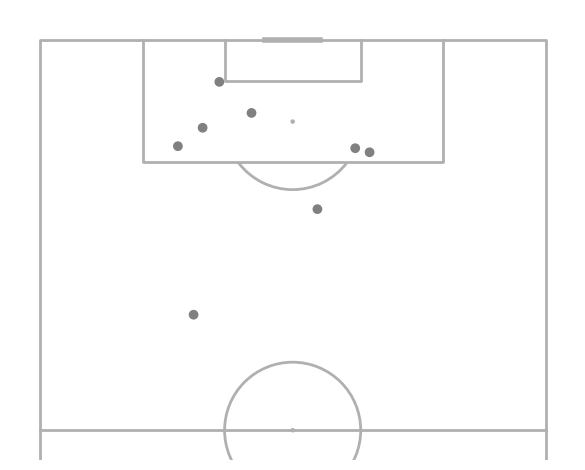

In [438]:
# shot map

from mplsoccer import Pitch, VerticalPitch
import plotly.express as px

shot['real_x'] = shot['x'] * 68
shot['real_y'] = shot['y'] * 105

outcome_mapping = {'Blocked': 'grey', 'Off Target': 'grey', 'Goal': 'red', 'On Target': 'grey', 'Missed': 'grey'}
shot['outcome_sep'] = shot['outcome'].map(outcome_mapping)


it_shot = shot[shot['teamId']==10757]
cz_shot = shot[shot['teamId']==10758]

pitch = VerticalPitch(half=True, pitch_type='uefa')

fig, ax = pitch.draw()


ax.scatter(cz_shot['real_x'], cz_shot['real_y'],c=cz_shot['outcome_sep'])

#plt.savefig('czech_shot_map.png')
#plt.show()


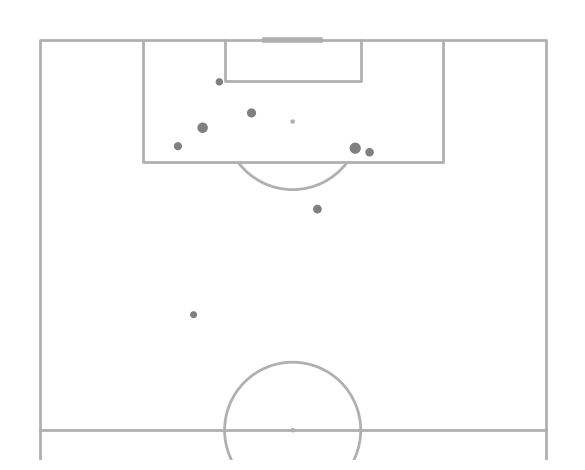

In [446]:
# xG map

pitch = VerticalPitch(half=True, pitch_type='uefa')

fig, ax = pitch.draw()

ax.scatter(
    cz_shot['real_x'], cz_shot['real_y'],
    c=cz_shot['outcome_sep'], s=cz_shot['xG']*500
)

#plt.savefig('czech_xg.png')
#plt.show()

In [407]:
# match info.

#df.pivot_table(values='eventId',index='eventType',columns='teamId',aggfunc='count')
df.pivot_table(values='eventType',index='cross',columns='teamId',aggfunc='count')

teamId,10757,10758
cross,,
False,654,385
True,17,18


In [373]:
#seq_data.groupby("teamId")["length"].count()
#seq_data.groupby('teamId')['length'].mean()
#seq_data.groupby('teamId')['length'].max()
#seq_data.groupby('teamId')['seq_time'].mean()

goals = df[df['outcome'] == 'Goal']
goal_seq = []

for idx, rec in seq_data.iterrows():
    if rec['eventIds'][-1] in goals['eventId'].tolist():
        goal_seq.append(rec)

# 17
goal_seq = pd.DataFrame(goal_seq)
goal_exp = goal_seq.explode('eventIds')
goal_exp = goal_exp.rename(columns={'eventIds': 'eventId'})
goal_seq_merge = pd.merge(goal_exp, df,
                          on='eventId')

time = 0
remove = []
for idx, rec in goal_seq_merge.iterrows():
    if rec['time_sec'] == time:
        remove.append(idx)
    time = rec['time_sec']
goal_seq_merge.drop(remove, inplace=True)

goal_seq_t = goal_seq_merge[['start_sec','end_sec','seq_time', 'eventId', 'eventTime',
                             'length','eventType','outcome','cross','keyPass',
                             'assist','xG','bodyPart','x','y','playerName','playerLastName']]

goal_seq_t = goal_seq_t.sort_values('seq_time')
#goal_seq_t.to_csv('goals sequence.csv')


""
0
1
12
11
8
10
18
14
15
16


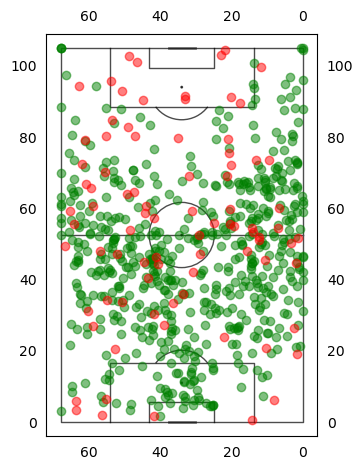

In [411]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch

pass_map = df[df['eventType'] == 'Pass']
pass_map = pass_map[['teamId', 'playerId', 'eventId', 'x', 'y', 'eventType', 'outcome', 'keyPass', 'assist']]
pass_map['real_x'] = pass_map['x'] * 68
pass_map['real_y'] = pass_map['y'] * 105

# main, sub
pitch = VerticalPitch(pitch_type='uefa',  # example plotting a tracab pitch
                      pitch_length=105, pitch_width=68,
                      axis=True, label=True,
                      pitch_color='white', line_color='black',
                      line_alpha=0.7, goal_alpha=0.5, linewidth=1)

fig, ax = pitch.draw()

it_pass_suc = pass_map[(pass_map['teamId'] == 10757) & (pass_map['outcome'] == 'Successful')]
it_pass_fail = pass_map[(pass_map['teamId'] == 10757) & (pass_map['outcome'] == 'Unsuccessful')]
cz_pass_suc = pass_map[(pass_map['teamId'] == 10758) & (pass_map['outcome'] == 'Successful')]
cz_pass_fail = pass_map[(pass_map['teamId'] == 10758) & (pass_map['outcome'] == 'Unsuccessful')]

ax.scatter(it_pass_suc['real_x'], it_pass_suc['real_y'], color='g', cmap='viridis', alpha=0.5)
ax.scatter(it_pass_fail['real_x'], it_pass_fail['real_y'], color='r', cmap='viridis', alpha=0.5)

plt.savefig('italy_pass map.png')
plt.show()

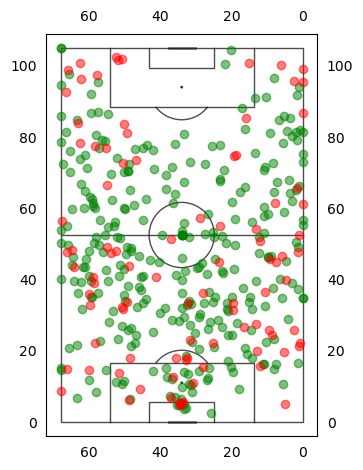

In [412]:
pitch = VerticalPitch(pitch_type='uefa',
                      pitch_length=105, pitch_width=68,
                      axis=True, label=True,
                      pitch_color='white', line_color='black',
                      line_alpha=0.7, goal_alpha=0.5, linewidth=1)

fig, ax = pitch.draw()

plt.scatter(cz_pass_suc['real_x'], cz_pass_suc['real_y'], color='g', cmap='viridis', alpha=0.5)
plt.scatter(cz_pass_fail['real_x'], cz_pass_fail['real_y'], color='r', cmap='viridis', alpha=0.5)

plt.savefig('czech_pass map.png')

plt.show()

In [409]:
def location_by_pass_cnt(data, loc): # attack / middle / defence
    if loc == 'attack':
        data = data[data['real_y'] >= 75]
        return len(data['eventType'])
    elif loc == 'middle':
        data = data[(data['real_y'] >= 35) & (data['real_y'] < 75)]
        return len(data['eventType'])
    else:
        data = data[data['real_y'] < 35]
        return len(data['eventType'])


print(f'이탈리아 공격지역 패스 성공 :{location_by_pass_cnt(it_pass_suc,"attack")}')
print(f"이탈리아 공격지역 패스 실패 :{location_by_pass_cnt(it_pass_fail, 'attack')}")

print(f'이탈리아 미들지역 패스 성공 :{location_by_pass_cnt(it_pass_suc,"middle")}')
print(f"이탈리아 미들지역 패스 실패 :{location_by_pass_cnt(it_pass_fail, 'middle')}")

print(f'이탈리아 수비지역 패스 성공 :{location_by_pass_cnt(it_pass_suc,"defence")}')
print(f"이탈리아 수비지역 패스 실패 :{location_by_pass_cnt(it_pass_fail, 'defence')}")

print('===================================')

print(f'체코 공격지역 패스 성공 :{location_by_pass_cnt(cz_pass_suc,"attack")}')
print(f"체코 공격지역 패스 실패 :{location_by_pass_cnt(cz_pass_fail, 'attack')}")

print(f'체코 미들지역 패스 성공 :{location_by_pass_cnt(cz_pass_suc,"middle")}')
print(f"체코 미들지역 패스 실패 :{location_by_pass_cnt(cz_pass_fail, 'middle')}")

print(f'체코 수비지역 패스 성공 :{location_by_pass_cnt(cz_pass_suc,"defence")}')
print(f"체코 수비지역 패스 실패 :{location_by_pass_cnt(cz_pass_fail, 'defence')}")

이탈리아 공격지역 패스 성공 :50
이탈리아 공격지역 패스 실패 :21
이탈리아 미들지역 패스 성공 :361
이탈리아 미들지역 패스 실패 :45
이탈리아 수비지역 패스 성공 :175
이탈리아 수비지역 패스 실패 :19
체코 공격지역 패스 성공 :49
체코 공격지역 패스 실패 :21
체코 미들지역 패스 성공 :156
체코 미들지역 패스 실패 :34
체코 수비지역 패스 성공 :104
체코 수비지역 패스 실패 :39


In [142]:
import seaborn as sns
import plotly.express as px
seq_data['teamName'] = seq_data['teamId'].apply(name)

seq_data['by-team_len'] = seq_data.groupby(['length', 'teamName'])['length'].transform('count')
seq_data = seq_data[seq_data['teamName']!='duel']
seq_data

,teamId,eventPeriod,startTime,endTime,eventIds,start_sec,end_sec,start_min,end_min,seq_time,length,teamName,by-team_len
0,10758.0,FIRST_HALF,996,6185,"[41254878, 41254879, 41254880, 41254881, 41254...",0.996,6.185,0.016600,0.103083,5.189,6,Czech Republic,14
2,10757.0,FIRST_HALF,8061,13394,"[41254911, 41254912, 41254913, 41254914, 41254...",8.061,13.394,0.134350,0.223233,5.333,6,Italy,11
4,10758.0,FIRST_HALF,14770,23031,"[41254891, 41254892, 41254893, 41254894, 41254...",14.770,23.031,0.246167,0.383850,8.261,9,Czech Republic,8
6,10757.0,FIRST_HALF,24445,32967,"[41254923, 41254936, 41254937, 41254943, 41254...",24.445,32.967,0.407417,0.549450,8.522,7,Italy,3
8,10758.0,FIRST_HALF,35638,43500,"[41254916, 41254920, 41254921, 41254922, 41254...",35.638,43.500,0.593967,0.725000,7.862,7,Czech Republic,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,10758.0,SECOND_HALF,5447114,5455285,"[41263402, 41263393, 41263394, 41263399]",5447.114,5455.285,90.785233,90.921417,8.171,4,Czech Republic,18
459,10758.0,SECOND_HALF,5470032,5473473,"[41263408, 41263409, 41263410, 41274673]",5470.032,5473.473,91.167200,91.224550,3.441,4,Czech Republic,18
461,10758.0,SECOND_HALF,5480504,5485959,"[41263418, 41263423]",5480.504,5485.959,91.341733,91.432650,5.455,2,Czech Republic,16
463,10757.0,SECOND_HALF,5489212,5499266,"[41274695, 41274696, 41274709, 41274710, 41274...",5489.212,5499.266,91.486867,91.654433,10.054,6,Italy,11


In [0]:
# sequence len compare

seq_df = seq_data[['teamName','length','by-team_len']]
seq_df = seq_df.sort_values('length', ascending=False).drop_duplicates().reset_index(drop=True)

# 16, 5


fig = px.bar(
    seq_df, x='length', y='by-team_len',color='teamName',
    labels={'length': 'Sequence Length', 'by-team_len': 'Count'},
)

fig.update_layout(
                xaxis=dict(showgrid=False), yaxis=dict(showgrid=False),
                plot_bgcolor='white', paper_bgcolor='white',
                font = dict(color='black'),
                    )

fig.show()

In [177]:

data = {'Italy': [16], 'Czech Republic': [5]}
dd = pd.DataFrame(data)

# 도넛 차트 그리기
fig = px.pie(dd, names=dd.columns,values=[16,5], hole=0.5)

# 레이아웃 설정
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color='black'),
)

fig.show()

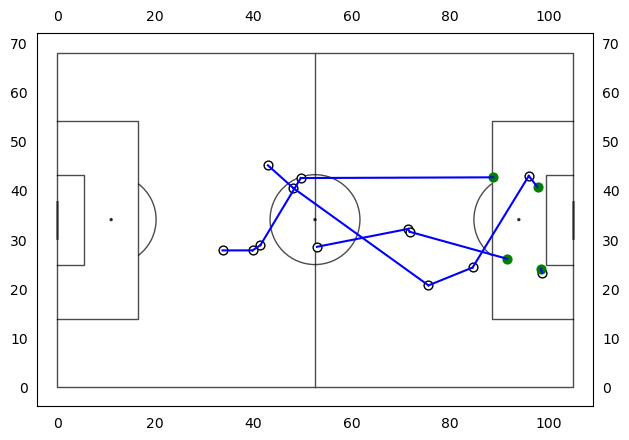

In [410]:
from mplsoccer import Pitch, VerticalPitch

goal_seq_t['real_x'] = goal_seq_t['y'].apply(lambda x: x * 105)
goal_seq_t['real_y'] = goal_seq_t['x'].apply(lambda x : x * 68)

goal_seq_t = goal_seq_t.sort_values(by='eventTime')
#plt.figure(facecolor='white')


pitch = Pitch(pitch_type='uefa',  # example plotting a tracab pitch
              pitch_length=105, pitch_width=68,
              axis=True, label=True,
              pitch_color='white', line_color='black',
                      line_alpha=0.7, goal_alpha=0.5, linewidth=1)  # showing axis labels is optional

fig, ax = pitch.draw()

time = None

for idx, ev in goal_seq_t.iterrows():
    if ev['outcome'] == 'Goal':
        ax.scatter(ev['real_x'], ev['real_y'], marker='o',color='green',s=40)
    else:
        ax.scatter(ev['real_x'], ev['real_y'], marker='o',
                    color='white',edgecolors='black',s=40)

    if time is not None and ev['start_sec'] == time:
        ax.plot([prev_x, ev['real_x']], [prev_y, ev['real_y']],
                 linestyle='-',color='blue', label=f'Point {idx}')

    prev_x, prev_y = ev['real_x'], ev['real_y']
    time = ev['start_sec']

'''plt.xlim(0, 105)
plt.ylim(0, 68)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_facecolor('white')'''
plt.savefig('italy_goal_sequence.png')

plt.show()

In [75]:
import plotly.express as px

pass_per_p = df[df['eventType'] == 'Pass'].groupby(
    ['teamId','playerName','playerLastName','playerId','eventType','outcome']).size().reset_index(name='pass_cnt') # to df

pass_stats = pass_per_p[pass_per_p['eventType'] == 'Pass'].groupby(
    ['teamId','playerId', 'playerName','playerLastName', 'outcome'])['pass_cnt'].sum().unstack().fillna(0)

pass_stats['accuracy'] = (pass_stats['Successful'] / (pass_stats['Successful'] + pass_stats['Unsuccessful'])) * 100

pass_stats_reset = pass_stats.reset_index()
def name(x):
    if x == 10757 or x==10757.0:
        x = 'Italy'
    else:
        x = 'Czech Republic'
    return x

pass_stats_reset['teamName'] = pass_stats_reset['teamId'].apply(name)
pass_stats_reset['name'] = pass_stats_reset['playerName'] + ' ' + pass_stats_reset['playerLastName']
pass_stats_reset = pass_stats_reset.sort_values(by='Successful', ascending=False)

pass_stats_reset

outcome,teamId,playerId,playerName,playerLastName,Successful,Unsuccessful,accuracy,teamName,name
8,10757,210309.0,Leonardo,Bonucci,82.0,11.0,88.172043,Italy,Leonardo Bonucci
0,10757,210301.0,Manuel,Locatelli,65.0,9.0,87.837838,Italy,Manuel Locatelli
5,10757,210306.0,Alessandro,Florenzi,57.0,9.0,86.363636,Italy,Alessandro Florenzi
25,10758,210332.0,Jakub,Brabec,54.0,8.0,87.096774,Czech Republic,Jakub Brabec
3,10757,210304.0,Lorenzo,Insigne,50.0,12.0,80.645161,Italy,Lorenzo Insigne
7,10757,210308.0,Giorgio,Chiellini,46.0,5.0,90.196078,Italy,Giorgio Chiellini
2,10757,210303.0,Jorginho,,43.0,4.0,91.489362,Italy,Jorginho
6,10757,210307.0,Gianluigi,Donnarumma,42.0,1.0,97.674419,Italy,Gianluigi Donnarumma
10,10757,210311.0,Nicolo,Barella,42.0,6.0,87.500000,Italy,Nicolo Barella
23,10758,210330.0,Vladimir,Coufal,34.0,9.0,79.069767,Czech Republic,Vladimir Coufal


In [81]:

'''
italy_pass = pass_stats[pass_stats['teamId']==10757.0]
czech_pass = pass_stats[pass_stats['teamId']==10758.0]
'''
# pass by player
fig = px.scatter(
                data_frame=pass_stats_reset, x="Successful", y="accuracy", color='teamName',
                labels={'accuracy': 'Pass Accuracy (%)', 'Successful':'Successful pass'}
)


fig.update_layout(
                xaxis=dict(showgrid=False), yaxis=dict(showgrid=False),
                plot_bgcolor='white', paper_bgcolor='white',
                font = dict(color='black'),
)

fig.show()

fig = px.bar(
             data_frame=pass_stats_reset, x='Successful', y='name', orientation='h',
             labels={'Successful' : 'Successful passes'}, color='teamName'
)

fig.update_layout(yaxis=dict(tickfont=dict(size=5)))

fig.update_layout(
                  xaxis=dict(showgrid=False), yaxis=dict(showgrid=False),
                  plot_bgcolor='white', paper_bgcolor='white',
                  font = dict(color='black')
)

fig.show()

In [15]:
#print(df['eventType'].unique())

xg_sum = df.groupby('teamId')['xG'].sum()
df.groupby(['teamId', 'eventType','cross','outcome'])['teamId'].count()
#df.groupby(['teamId', 'outcome'])['teamId'].count()

#xg_sum

teamId  eventType  cross  outcome     
10757   Pass       False  Successful      581
                          Unsuccessful     73
                   True   Successful        5
                          Unsuccessful     12
10758   Pass       False  Successful      305
                          Unsuccessful     80
                   True   Successful        4
                          Unsuccessful     14
Name: teamId, dtype: int64

In [16]:
import plotly.express as px

# total pass
fig = px.pie(values=[671, 403], names=['Itlay', 'Czech Republic'])
fig.update_traces(hole=.5, textinfo='value')
fig.show()

# pass accuracy
fig = px.pie(values=[87, 76], names=['Itlay', 'Czech Republic'])
fig.update_traces(hole=.5, textinfo='value')
fig.show()

# cross
fig = px.pie(values=[17, 18], names=['Itlay', 'Czech Republic'])
fig.update_traces(hole=.5, textinfo='value')
fig.show()

In [17]:
df = pd.DataFrame(data['events'])

df_event_types = pd.json_normalize(df['eventTypes'].explode(), sep='_')

df_result = pd.concat([df, df_event_types], axis=1)
df_result

,eventId,eventPeriod,eventTime,matchId,teamId,playerId,x,y,eventTypes,relativeEvent,ballPosition,eventType,outcome,cross,keyPass,assist,subEventType,bodyPart,xG,eventTypes
0,41254878.0,FIRST_HALF,996.0,32266.0,10758.0,210334.0,0.498980,0.500170,"[{'eventType': 'Pass', 'outcome': 'Successful'...","{'eventId': 41254879, 'playerId': 210329, 'x':...",NaN,Pass,Successful,False,False,False,NaN,NaN,NaN,NaN
1,41254879.0,FIRST_HALF,1901.0,32266.0,10758.0,210329.0,0.492469,0.403253,[{'eventType': 'Pass Received'}],NaN,NaN,Pass Received,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,41254880.0,FIRST_HALF,2716.0,32266.0,10758.0,210329.0,0.522906,0.392473,"[{'eventType': 'Pass', 'outcome': 'Successful'...","{'eventId': 41254881, 'playerId': 210331, 'x':...",NaN,Pass,Successful,False,False,False,NaN,NaN,NaN,NaN
3,41254881.0,FIRST_HALF,3964.0,32266.0,10758.0,210331.0,0.749408,0.300976,[{'eventType': 'Pass Received'}],NaN,NaN,Pass Received,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,41254883.0,FIRST_HALF,4892.0,32266.0,10758.0,210331.0,0.784955,0.296348,"[{'eventType': 'Pass', 'outcome': 'Successful'...","{'eventId': 41254884, 'playerId': 210330, 'x':...",NaN,Pass,Successful,False,False,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass,Successful,False,False,False,NaN,NaN,NaN,NaN
2798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Set Piece,NaN,NaN,NaN,NaN,Freekick,NaN,NaN,NaN
2799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass Received,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass,Successful,False,False,False,NaN,NaN,NaN,NaN


* Tracking Data processing(.txt)


In [351]:
import requests

url = 'https://file.notion.so/f/f/e6d8df69-733e-4793-ae23-13bbf3253b75/7902a2fb-ece6-4064-b76e-e9720681424c/Italy_vs_Czech_Republic_(04.06.2021)_FIRST_HALF.txt?id=b326b77d-5067-48bf-94f2-e792ffbbab9a&table=block&spaceId=e6d8df69-733e-4793-ae23-13bbf3253b75&expirationTimestamp=1703318400000&signature=jVqpMcL1DIs2n45hl-ZU9mxDv9lqBf7ISJOaPZPXwQo&downloadName=Italy+vs+Czech+Republic+%2804.06.2021%29_FIRST_HALF.txt'

response = requests.get(url)

with open('Italy_Czech.txt', 'w', encoding='utf-8') as file:
    file.write(response.text)

In [0]:
with open('Italy_Czech.txt', 'r', encoding='utf-8') as file:
    file = file.read()
    #status =['HOME', 'AWAY', 'NEUTRAL', 'BALL_OUT']
    raw = file.split(':')

ids, players, ball = [], [], []
tag = 0
for raws in raw:
    tag = 0 if tag == 3 else tag
    if tag == 0:
        if raws == '251':
            ids.append(raws)
        else:
            s = raws.split("\n")
            if len(s) > 1:
                ids.append(s[1])
            else:
                ids.append("")
            s = []  # s 초기화
    elif tag == 1:
        players.append(raws)
    elif tag == 2:
        ball.append(raws)

    tag += 1

# 7500 7750
ids = ids[:8000]
players = players[:8000]
ball = ball[:8000] # tag

In [0]:
player_lst = []
for player in players:
    p = player.split(';')
    player_lst.append(p) # tag

In [417]:
t_df = pd.DataFrame({
    'id' : ids,
     'players' : player_lst,
     'ball':ball
})
tracking = pd.DataFrame({
    'id':ids
})

def ball_x(x):
    return x.split(',')[0]

def ball_y(x):
    return x.split(',')[1]

tracking['ball_x'] = t_df['ball'].apply(ball_x)
tracking['ball_y'] = t_df['ball'].apply(ball_y)

for i in range(len(t_df['players'][0])):
    if i < 11:
        tracking[f'H{i+1}_x'] = t_df['players'].apply(lambda x : x[i].split(',')[0])
        tracking[f'H{i+1}_y'] = t_df['players'].apply(lambda x : x[i].split(',')[1])
    else:
        tracking[f'A{i+1}_x'] = t_df['players'].apply(lambda x : x[i].split(',')[0])
        tracking[f'A{i+1}_y'] = t_df['players'].apply(lambda x : x[i].split(',')[1])

t_df

,id,players,ball
0,251,"[4419,2283, 3684,828, 4274,3249, 5220,2336, 52...","5250,3400"
1,252,"[4419,2283, 3684,827, 4274,3249, 5221,2336, 52...","5250,3400"
2,253,"[4419,2283, 3684,827, 4274,3249, 5221,2336, 52...","5250,3401"
3,254,"[4419,2282, 3683,825, 4274,3249, 5221,2336, 52...","5250,3401"
4,255,"[4418,2282, 3683,824, 4274,3249, 5221,2336, 52...","5250,3401"
...,...,...,...
7995,8246,"[3569,1691, 3040,284, 2789,2351, 3625,510, 490...","2967,588"
7996,8247,"[3559,1678, 3030,285, 2775,2340, 3615,499, 489...","2944,627"
7997,8248,"[3549,1664, 3019,281, 2761,2329, 3604,488, 489...","2922,665"
7998,8249,"[3539,1650, 3008,275, 2746,2318, 3594,477, 489...","2901,701"


In [419]:
#tracking.to_csv('tracking_data(5min)_sep.csv')